In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 1000


# Identification part of the filenames
model_base_name = 'RAE_NoShifting_ExtendedRange_MoreLeftOut_Combined1Distribution'
base_name = 'NoShifting_ExtendedRange_MoreLeftOut_Combined1Distribution'    # This is the dataset base name
base_dir = '/path/to/base/directory'   # Set base directory

## Train Transformer on dataset of 44 metabolites

In [2]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"Transformer_44met_{model_base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir(base_dir+'/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [3]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra = np.load(f'Dataset44_{base_name}_ForManuscript_Spec.npy')
conc1 = np.load(f'Dataset44_{base_name}_ForManuscript_Conc.npy')

In [4]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [5]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
#spectraVal = torch.tensor(spectraVal).float().to(device)   # Confusing names, these spectra are the 5000 spectra generated like the training dataset
#ValSpectra = torch.tensor(ValSpectra).float().to(device)   # Confusing names, these spectra are the 10 representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
#concVal = torch.tensor(concVal).float().to(device)
#ValConc = torch.tensor(ValConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 76, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 76, shuffle=True)

In [6]:
del X_train
del X_test
del y_train
del y_test
del spectra
del conc1
del datasets
del Test_datasets

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(23552, 44)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Transformer Encoder
        x = x.permute(1, 0, 2)  # (num_bins, batch_size, d_model)
        x = self.transformer_encoder(x)  # (num_bins, batch_size, d_model)
        x = x.permute(1, 0, 2)  # (batch_size, num_bins, d_model)
        
        # Reconstruct original sequence
        x = x.reshape(batch_size, num_bins * d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, output_dim)
        
        return x

# Parameters
input_dim = 1000  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 1         # Number of attention heads
num_encoder_layers = 1  # Number of transformer encoder layers
dim_feedforward = 2048  # Feedforward dimension
dropout = 0.0     # Dropout rate


In [8]:
class RelativeAbsoluteError(nn.Module):
    def __init__(self):
        super(RelativeAbsoluteError, self).__init__()

    def forward(self, y_pred, y_true):
        # Compute the mean of the true values
        y_mean = torch.mean(y_true)
        
        # Compute the absolute differences
        absolute_errors = torch.abs(y_true - y_pred)
        mean_absolute_errors = torch.abs(y_true - y_mean)
        
        # Compute RAE
        rae = torch.sum(absolute_errors) / torch.sum(mean_absolute_errors)
        return rae

In [9]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = RelativeAbsoluteError()
    optimizer = optim.AdamW(model.parameters(), lr=0.00014656680844397094, weight_decay=0.01)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
            
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
            
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break



    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [10]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Create model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


No pretrained model found. Training from scratch.
Epoch [1/1000], Train Loss: 9623.6447, Test Loss: 2154.9267
Epoch [2/1000], Train Loss: 8505.5854, Test Loss: 2116.1354
Epoch [3/1000], Train Loss: 8400.8446, Test Loss: 2085.4262
Epoch [4/1000], Train Loss: 8229.4723, Test Loss: 2016.8565
Epoch [5/1000], Train Loss: 7697.2265, Test Loss: 1840.6696
Epoch [6/1000], Train Loss: 6550.7685, Test Loss: 1402.6373
Epoch [7/1000], Train Loss: 4530.7707, Test Loss: 912.7818
Epoch [8/1000], Train Loss: 3040.5404, Test Loss: 660.4070
Epoch [9/1000], Train Loss: 2163.7038, Test Loss: 476.2169
Epoch [10/1000], Train Loss: 1626.7681, Test Loss: 355.5667
Epoch [11/1000], Train Loss: 1246.5559, Test Loss: 281.0576
Epoch [12/1000], Train Loss: 1009.1520, Test Loss: 242.6648
Epoch [13/1000], Train Loss: 852.9627, Test Loss: 217.7463
Epoch [14/1000], Train Loss: 740.6690, Test Loss: 183.3632
Epoch [15/1000], Train Loss: 660.3199, Test Loss: 164.8631
Epoch [16/1000], Train Loss: 619.7206, Test Loss: 161.22

Epoch [140/1000], Train Loss: 208.4948, Test Loss: 66.8739
Epoch [141/1000], Train Loss: 212.9882, Test Loss: 56.5445
Epoch [142/1000], Train Loss: 206.3748, Test Loss: 57.5526
Epoch [143/1000], Train Loss: 207.1464, Test Loss: 58.2132
Epoch [144/1000], Train Loss: 208.8397, Test Loss: 52.0828
Epoch [145/1000], Train Loss: 205.2217, Test Loss: 55.2417
Epoch [146/1000], Train Loss: 204.3021, Test Loss: 67.5321
Epoch [147/1000], Train Loss: 205.6553, Test Loss: 57.1114
Epoch [148/1000], Train Loss: 205.9201, Test Loss: 54.8059
Epoch [149/1000], Train Loss: 201.4712, Test Loss: 52.2968
Epoch [150/1000], Train Loss: 198.9820, Test Loss: 50.3936
Epoch [151/1000], Train Loss: 199.9651, Test Loss: 51.4983
Epoch [152/1000], Train Loss: 200.3089, Test Loss: 51.0787
Epoch [153/1000], Train Loss: 201.8297, Test Loss: 57.2598
Epoch [154/1000], Train Loss: 200.7062, Test Loss: 53.5246
Epoch [155/1000], Train Loss: 201.8679, Test Loss: 54.7302
Epoch [156/1000], Train Loss: 198.1828, Test Loss: 50.84

Epoch [279/1000], Train Loss: 159.8164, Test Loss: 38.8111
Epoch [280/1000], Train Loss: 157.2303, Test Loss: 42.0600
Epoch [281/1000], Train Loss: 158.6367, Test Loss: 43.1176
Epoch [282/1000], Train Loss: 154.3090, Test Loss: 44.4128
Epoch [283/1000], Train Loss: 157.2733, Test Loss: 42.3037
Epoch [284/1000], Train Loss: 159.6050, Test Loss: 39.9632
Epoch [285/1000], Train Loss: 152.8956, Test Loss: 41.8567
Epoch [286/1000], Train Loss: 159.0921, Test Loss: 42.6738
Epoch [287/1000], Train Loss: 157.6549, Test Loss: 39.6331
Epoch [288/1000], Train Loss: 157.9463, Test Loss: 41.2752
Epoch [289/1000], Train Loss: 154.2391, Test Loss: 42.0624
Epoch [290/1000], Train Loss: 161.1835, Test Loss: 43.0864
Epoch [291/1000], Train Loss: 155.2531, Test Loss: 43.0254
Epoch [292/1000], Train Loss: 153.2087, Test Loss: 38.9423
Epoch [293/1000], Train Loss: 158.0497, Test Loss: 40.0546
Epoch [294/1000], Train Loss: 155.6963, Test Loss: 40.3601
Epoch [295/1000], Train Loss: 153.9642, Test Loss: 43.80

Epoch [418/1000], Train Loss: 136.1608, Test Loss: 37.6184
Epoch [419/1000], Train Loss: 134.8970, Test Loss: 39.2497
Epoch [420/1000], Train Loss: 134.3886, Test Loss: 36.7305
Epoch [421/1000], Train Loss: 134.4218, Test Loss: 37.3461
Epoch [422/1000], Train Loss: 134.3406, Test Loss: 36.1660
Epoch [423/1000], Train Loss: 135.4506, Test Loss: 34.6140
Epoch [424/1000], Train Loss: 137.0913, Test Loss: 36.3461
Epoch [425/1000], Train Loss: 137.4144, Test Loss: 34.8789
Epoch [426/1000], Train Loss: 136.0871, Test Loss: 40.7611
Epoch [427/1000], Train Loss: 132.7736, Test Loss: 33.5805
Epoch [428/1000], Train Loss: 134.3159, Test Loss: 39.6108
Epoch [429/1000], Train Loss: 139.2230, Test Loss: 34.3913
Epoch [430/1000], Train Loss: 136.3170, Test Loss: 35.3768
Epoch [431/1000], Train Loss: 135.5374, Test Loss: 39.5197
Epoch [432/1000], Train Loss: 134.6760, Test Loss: 34.6531
Epoch [433/1000], Train Loss: 132.1155, Test Loss: 35.9925
Epoch [434/1000], Train Loss: 133.4580, Test Loss: 37.14

Epoch [557/1000], Train Loss: 123.0887, Test Loss: 36.1661
Epoch [558/1000], Train Loss: 125.3432, Test Loss: 33.2972
Epoch [559/1000], Train Loss: 123.6300, Test Loss: 31.7349
Epoch [560/1000], Train Loss: 122.4945, Test Loss: 32.3274
Epoch [561/1000], Train Loss: 125.4772, Test Loss: 33.9550
Epoch [562/1000], Train Loss: 125.0105, Test Loss: 32.9947
Epoch [563/1000], Train Loss: 120.5841, Test Loss: 31.0279
Epoch [564/1000], Train Loss: 122.3645, Test Loss: 36.2010
Epoch [565/1000], Train Loss: 123.5801, Test Loss: 37.9430
Epoch [566/1000], Train Loss: 125.4666, Test Loss: 32.3692
Epoch [567/1000], Train Loss: 119.5524, Test Loss: 33.3766
Epoch [568/1000], Train Loss: 122.9781, Test Loss: 33.4044
Epoch [569/1000], Train Loss: 123.3467, Test Loss: 32.7671
Epoch [570/1000], Train Loss: 121.7925, Test Loss: 31.9913
Epoch [571/1000], Train Loss: 122.3709, Test Loss: 35.9096
Epoch [572/1000], Train Loss: 123.7295, Test Loss: 32.2830
Epoch [573/1000], Train Loss: 120.1310, Test Loss: 32.70

In [11]:
np.array(test_losses).min()

29.718127314932644

In [13]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Spec.npy')
concVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_44met_{base_name}_ForManuscript_Spec.npy')
ConcConc = np.load(f'Concentration_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Spec.npy')
UniformConc = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Spec.npy')
LowUniformConc = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeConc = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Conc = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_44met_{base_name}_ForManuscript_Spec.npy')
SNR_Conc = np.load(f'SNR_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_44met_{base_name}_ForManuscript_Spec.npy')
Singlet_Conc = np.load(f'Singlet_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Spec.npy')
QrefSensConc = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Spec.npy')
OtherValConc = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [14]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (embedding): Linear(in_features=1000, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=23552, out_features=44, bias=True)
)

In [15]:
Prediction = model_aq(spectraVal[0].unsqueeze(0))

Prediction

tensor([[10.4624,  0.6589, 13.1333, 10.3848, 10.0697,  7.8473,  4.9713, 14.8004,
          7.1146,  6.3667, 14.8424, 12.7272,  3.2664, 12.3118,  4.4774, 18.7120,
         20.4763, 11.8852, 20.2471,  1.8967, 12.1827,  1.5085, 10.2958,  2.3113,
          3.0847, 14.2912,  5.4280,  2.5870,  5.2866,  8.3388, 11.2420,  4.8245,
         15.4496, 11.6861, 12.2021,  9.2281, 19.0596, 13.8571,  3.8408, 16.8117,
         23.1412, 12.0138, 21.3646,  8.1532]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [16]:
Prediction.detach().cpu().numpy()[0]

array([10.462427 ,  0.6589313, 13.133297 , 10.384751 , 10.069736 ,
        7.8472514,  4.971284 , 14.80039  ,  7.1146407,  6.3666725,
       14.842407 , 12.727235 ,  3.2663531, 12.311783 ,  4.477368 ,
       18.711983 , 20.476334 , 11.885159 , 20.247116 ,  1.8967412,
       12.182652 ,  1.5085362, 10.295828 ,  2.3113234,  3.0846672,
       14.291204 ,  5.4279766,  2.587016 ,  5.286633 ,  8.338781 ,
       11.2419615,  4.8245406, 15.4496355, 11.686099 , 12.202125 ,
        9.228073 , 19.059605 , 13.857143 ,  3.8408113, 16.811672 ,
       23.141178 , 12.013768 , 21.364563 ,  8.153204 ], dtype=float32)

In [17]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()  # Move GroundTruth tensor to CPU and convert to NumPy array
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()[0]

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  42.76936730367469


In [18]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
80.92  - Concentrations: 0.004999999888241291
15.07  - Concentrations: 0.02500000037252903
3.98  - Concentrations: 0.10000000149011612
1.68  - Concentrations: 0.25
0.83  - Concentrations: 0.5
0.61  - Concentrations: 1.0
0.44  - Concentrations: 2.5
0.34  - Concentrations: 10.0
0.51  - Concentrations: 20.0


In [19]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  1.8686533
--------------------
0.7  - Min Value: 0.6783  - Mean Value: 9.2
10.62  - Min Value: 0.0096  - Mean Value: 10.3
1.2  - Min Value: 0.147  - Mean Value: 10.5
1.3  - Min Value: 0.5572  - Mean Value: 8.5
0.68  - Min Value: 1.3567  - Mean Value: 10.6
0.74  - Min Value: 0.6332  - Mean Value: 10.9
0.81  - Min Value: 0.7017  - Mean Value: 11.0
1.48  - Min Value: 0.3674  - Mean Value: 8.9
0.62  - Min Value: 0.8387  - Mean Value: 9.8
0.53  - Min Value: 1.0913  - Mean Value: 11.1


In [20]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  5.4268155
--------------------
4.65  - Min Value: 0.0111  - Mean Value: 0.1
6.9  - Min Value: 0.0103  - Mean Value: 0.1
4.44  - Min Value: 0.0153  - Mean Value: 0.1
6.44  - Min Value: 0.0117  - Mean Value: 0.1
6.0  - Min Value: 0.0089  - Mean Value: 0.1
5.24  - Min Value: 0.0075  - Mean Value: 0.1
5.84  - Min Value: 0.0117  - Mean Value: 0.1
5.06  - Min Value: 0.0052  - Mean Value: 0.1
5.22  - Min Value: 0.008  - Mean Value: 0.1
4.49  - Min Value: 0.0134  - Mean Value: 0.1


In [21]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  7.105667
--------------------
10.42  - Min Value: 0.008  - Mean Value: 0.8
15.61  - Min Value: 0.009  - Mean Value: 0.9
10.77  - Min Value: 0.0138  - Mean Value: 1.5
4.12  - Min Value: 0.0107  - Mean Value: 0.7
4.72  - Min Value: 0.0191  - Mean Value: 0.7
4.47  - Min Value: 0.0186  - Mean Value: 0.8
5.83  - Min Value: 0.0175  - Mean Value: 0.8
4.23  - Min Value: 0.0238  - Mean Value: 1.3
3.61  - Min Value: 0.0168  - Mean Value: 0.7
7.27  - Min Value: 0.0171  - Mean Value: 0.9


In [22]:
APEs[0]

[tensor(1.6097),
 tensor(1.8692),
 tensor(1.4734),
 tensor(34.1500),
 tensor(17.3746),
 tensor(6.4514),
 tensor(35.9489),
 tensor(3.6309),
 tensor(9.5438),
 tensor(5.5455),
 tensor(0.6052),
 tensor(9.2684),
 tensor(0.3490),
 tensor(1.5942),
 tensor(51.0789),
 tensor(5.6880),
 tensor(3.6233),
 tensor(15.7124),
 tensor(0.9168),
 tensor(6.7658),
 tensor(0.1017),
 tensor(0.2539),
 tensor(23.9752),
 tensor(13.0154),
 tensor(0.4849),
 tensor(0.4144),
 tensor(7.2225),
 tensor(6.1554),
 tensor(0.0593),
 tensor(66.9930),
 tensor(0.1913),
 tensor(5.7837),
 tensor(0.6644),
 tensor(2.5608),
 tensor(11.4889),
 tensor(23.2636),
 tensor(38.5669),
 tensor(0.3806),
 tensor(5.8850),
 tensor(9.1746),
 tensor(9.3488),
 tensor(0.4533),
 tensor(0.2147),
 tensor(18.7283)]

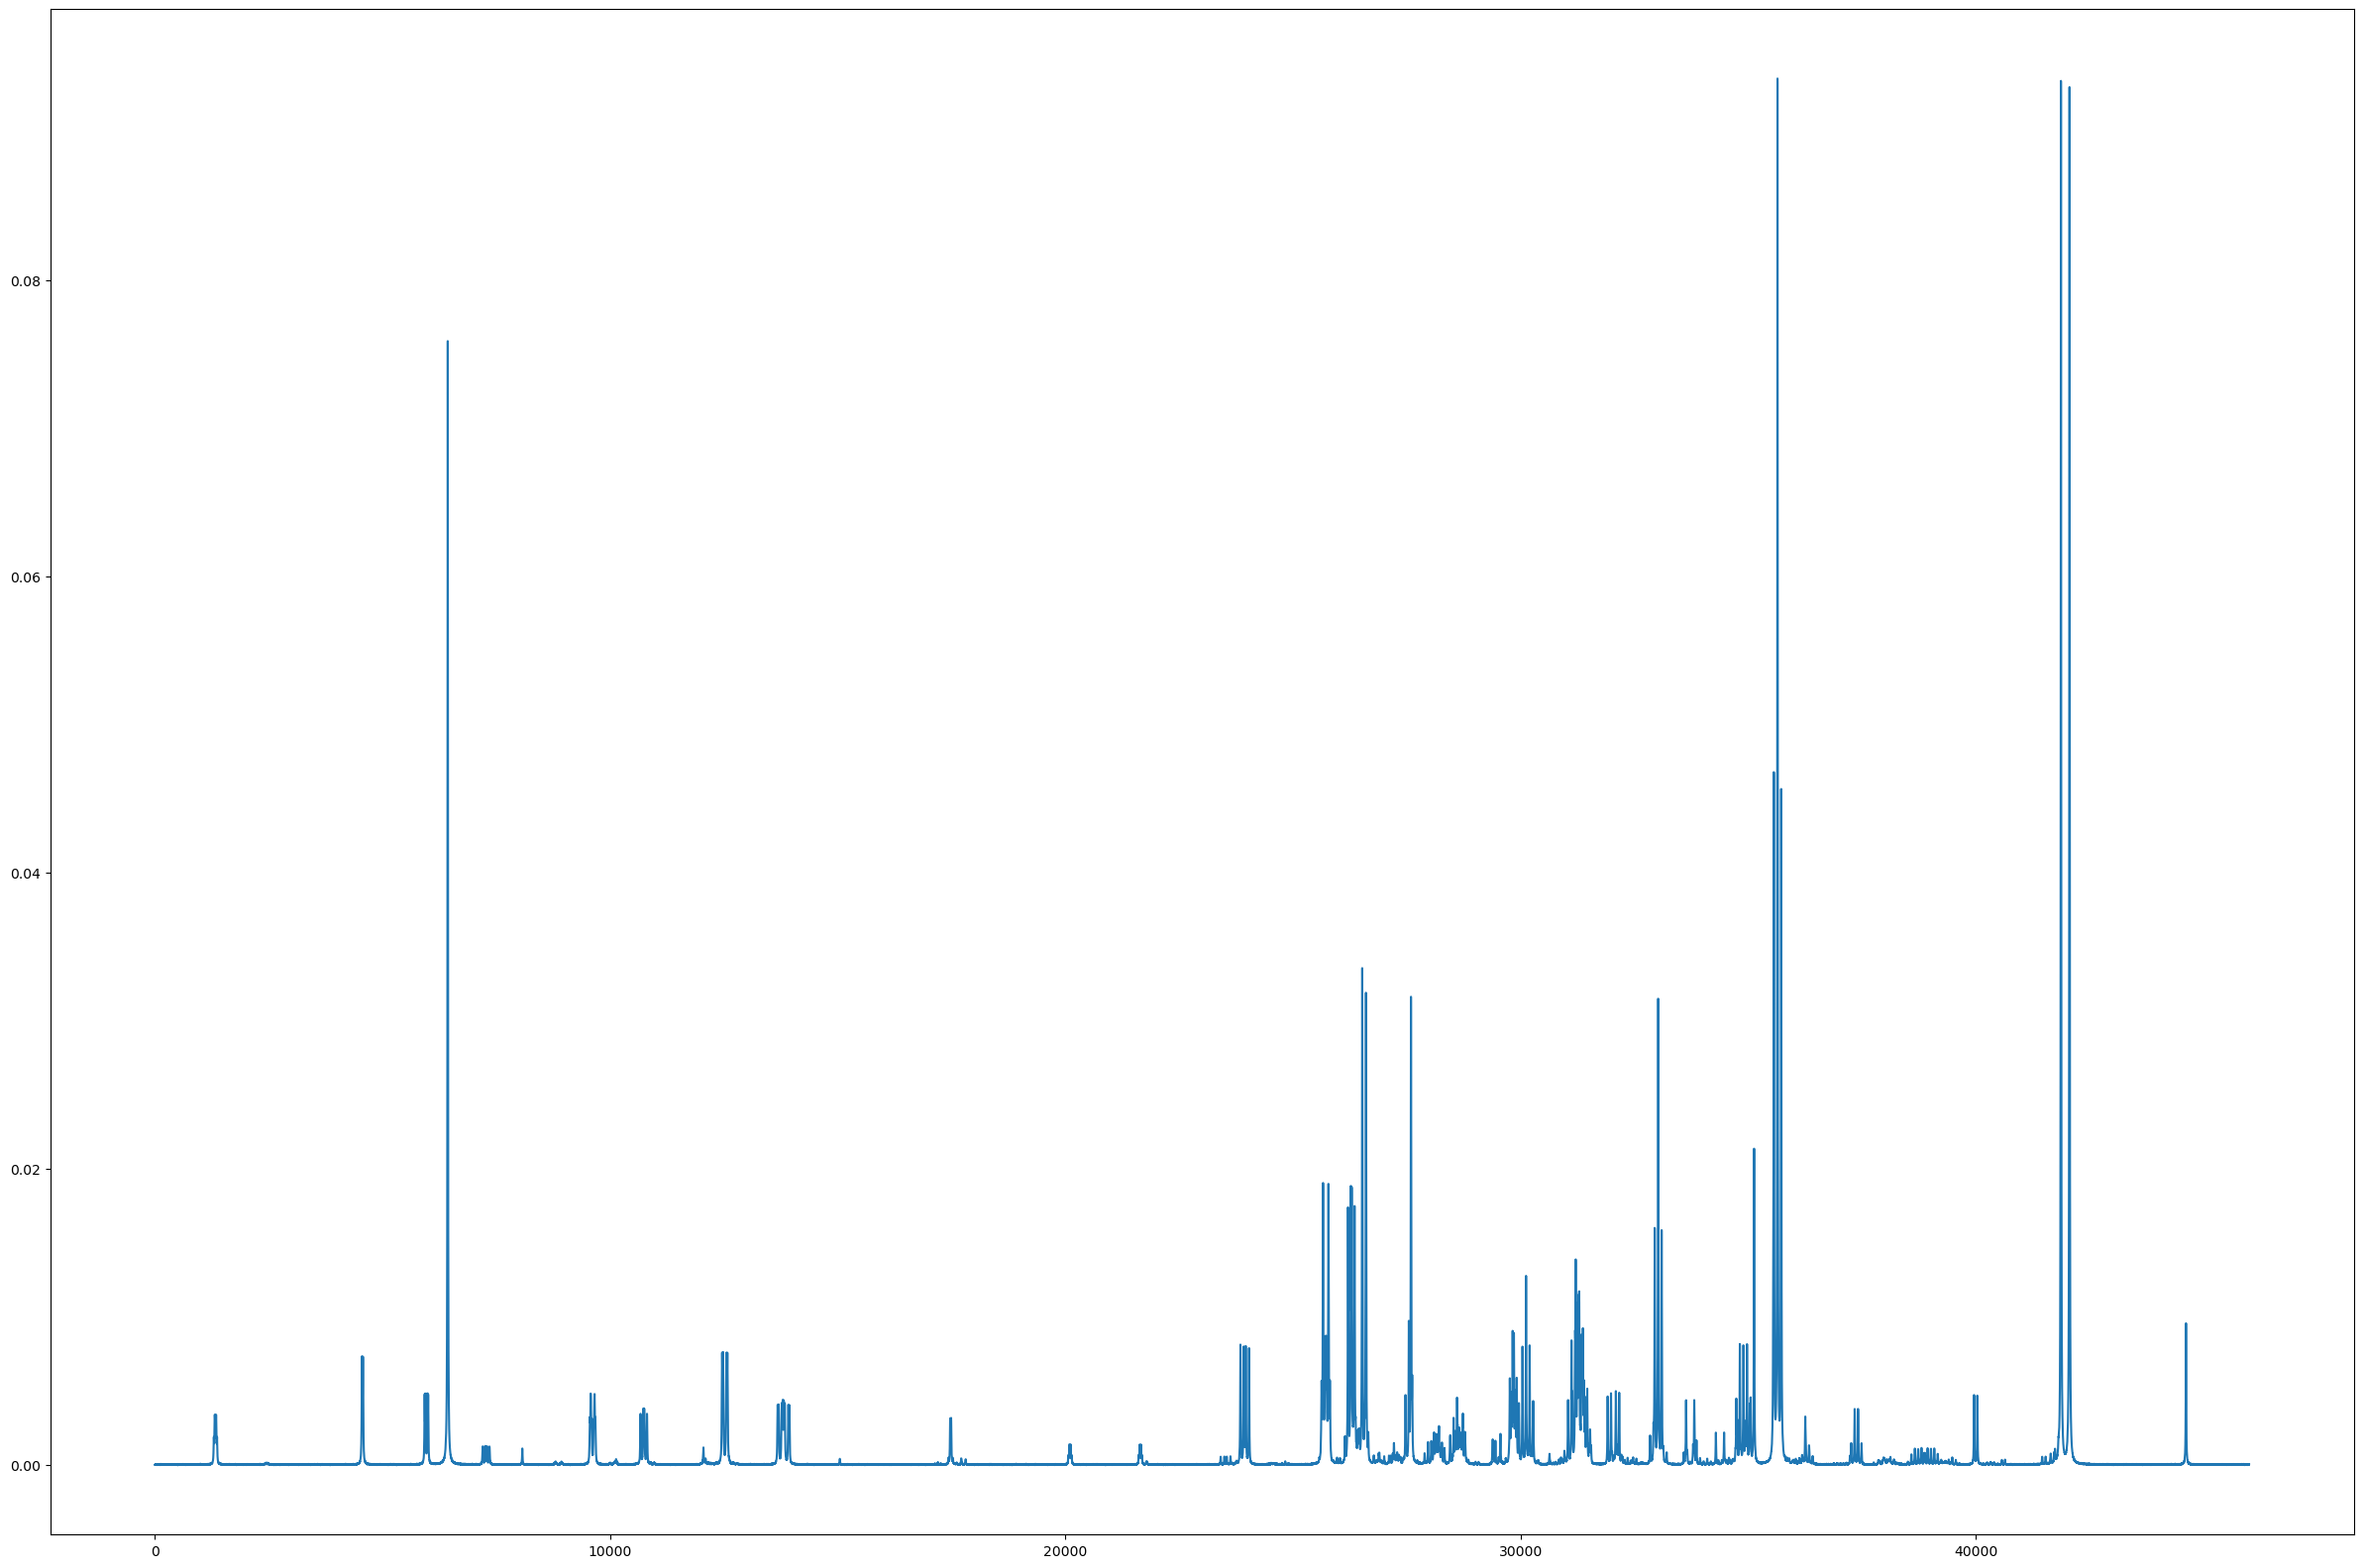

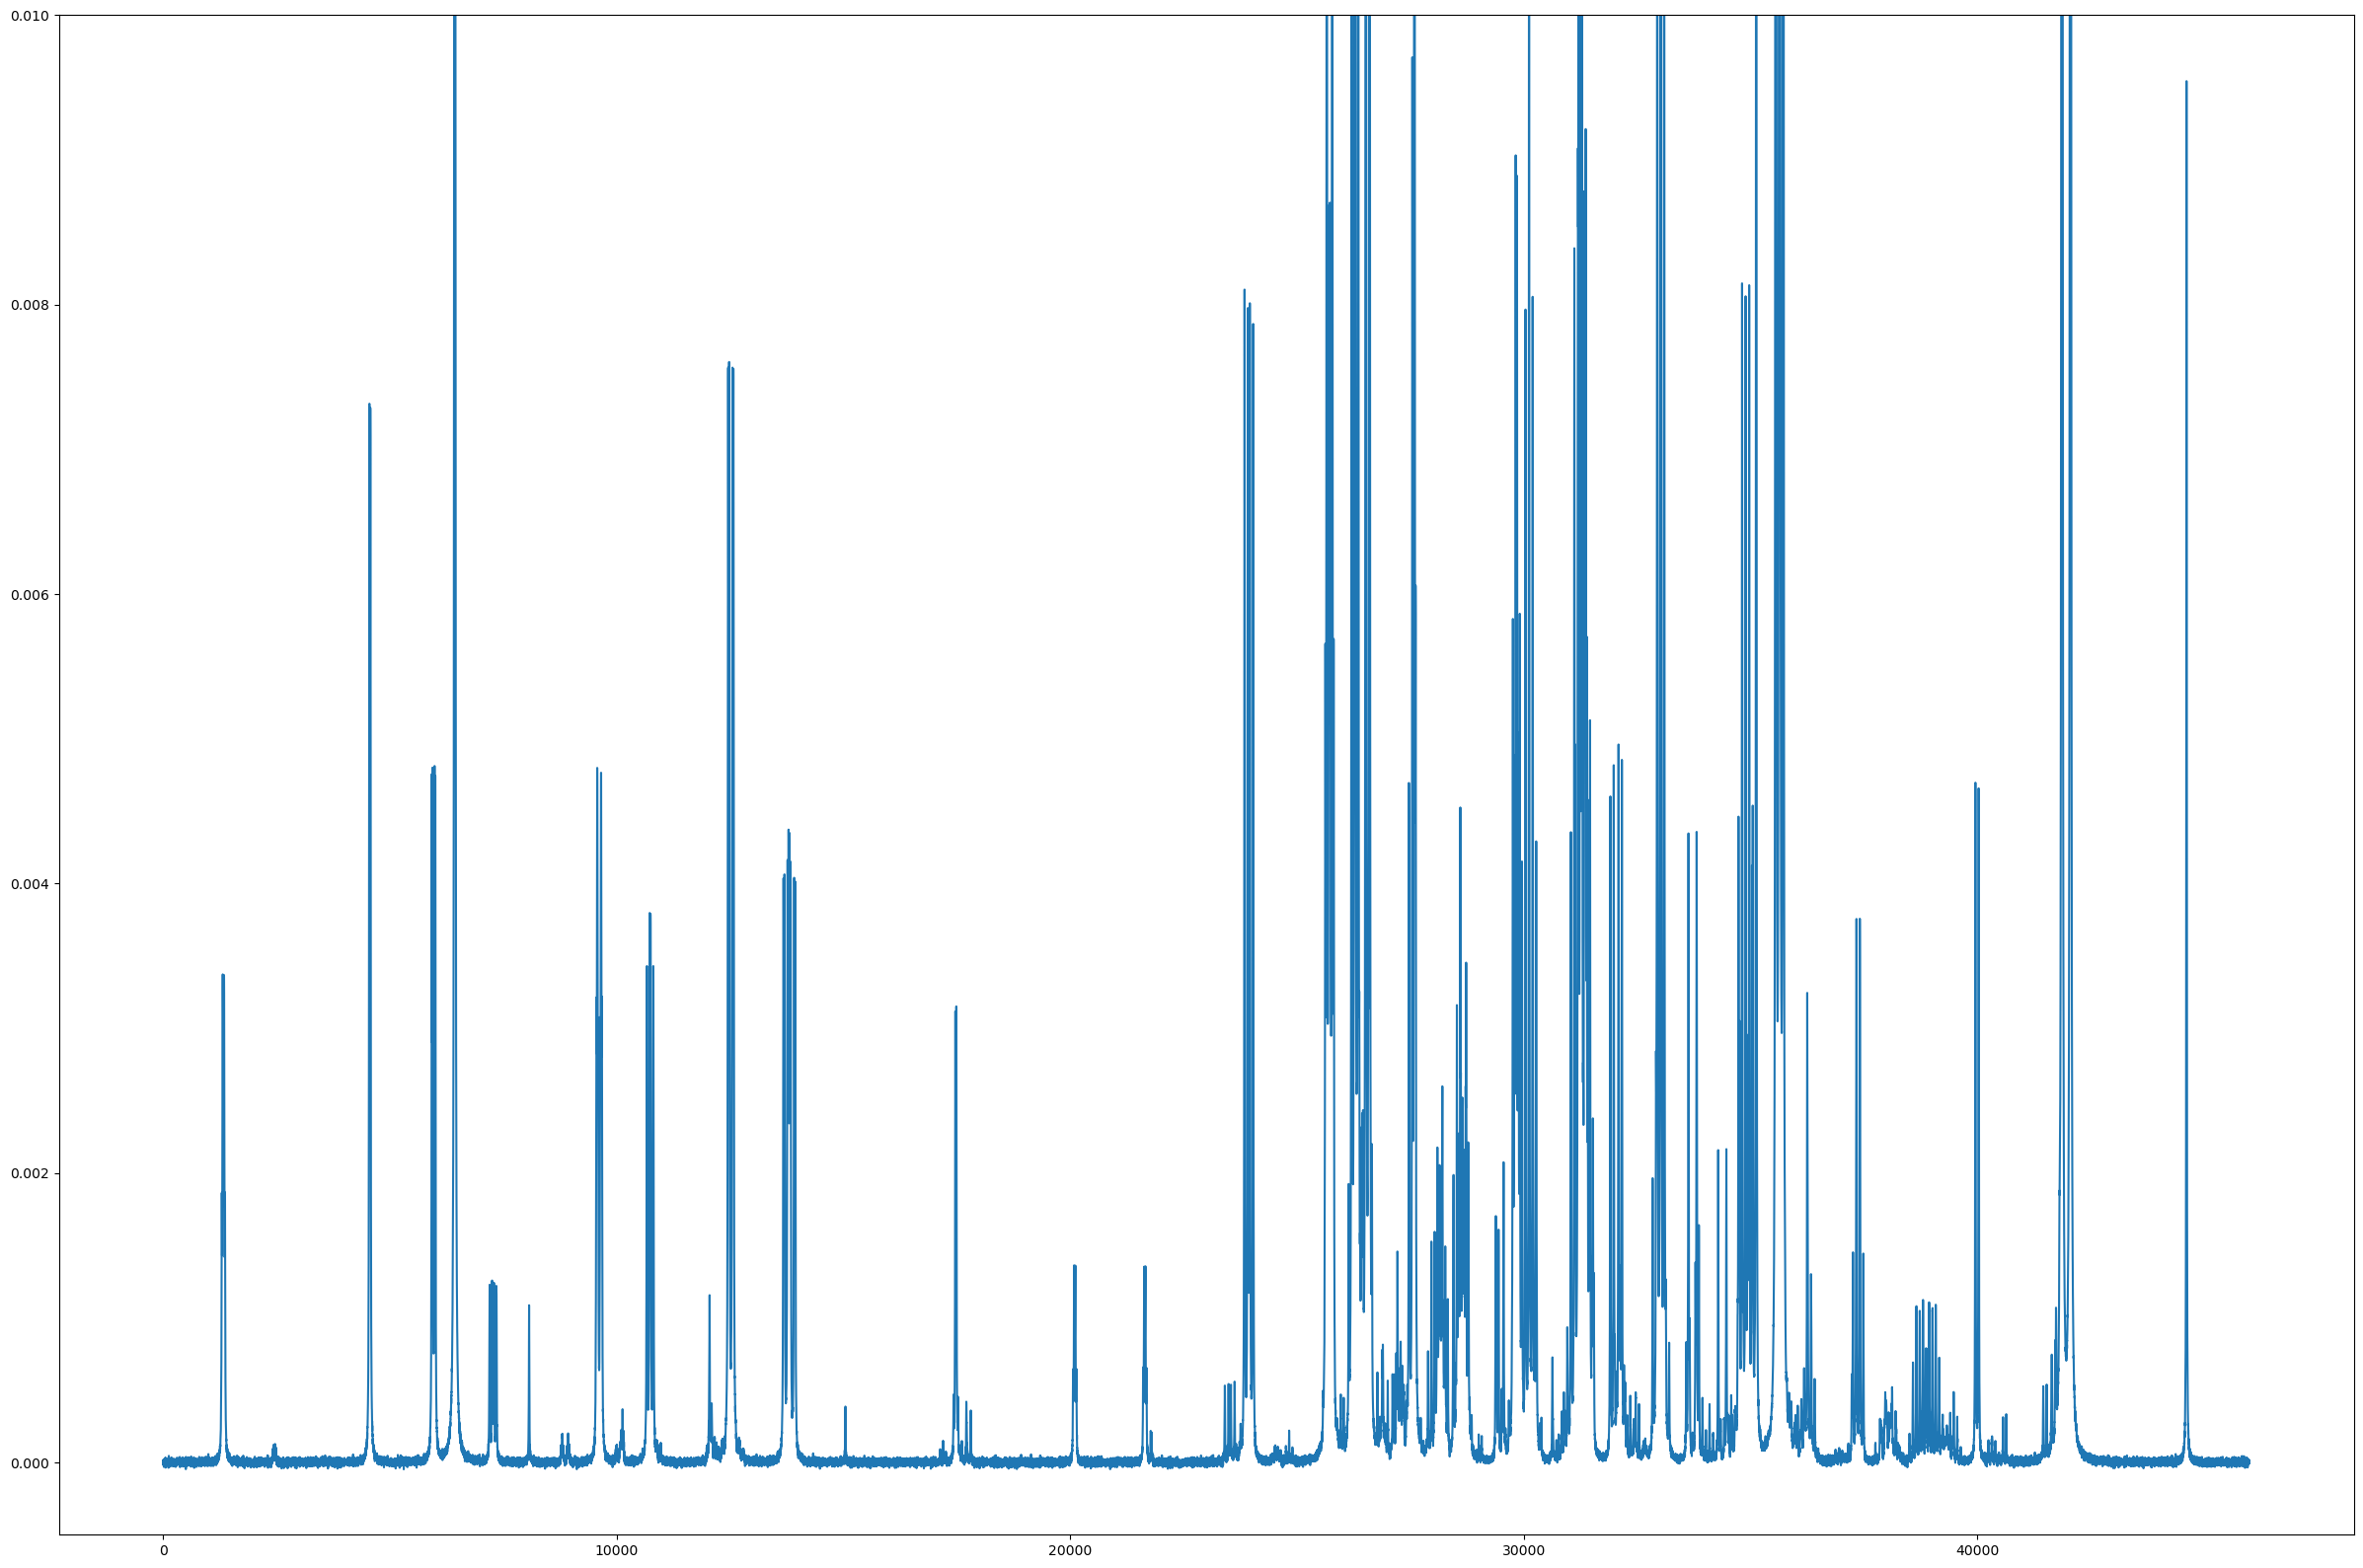

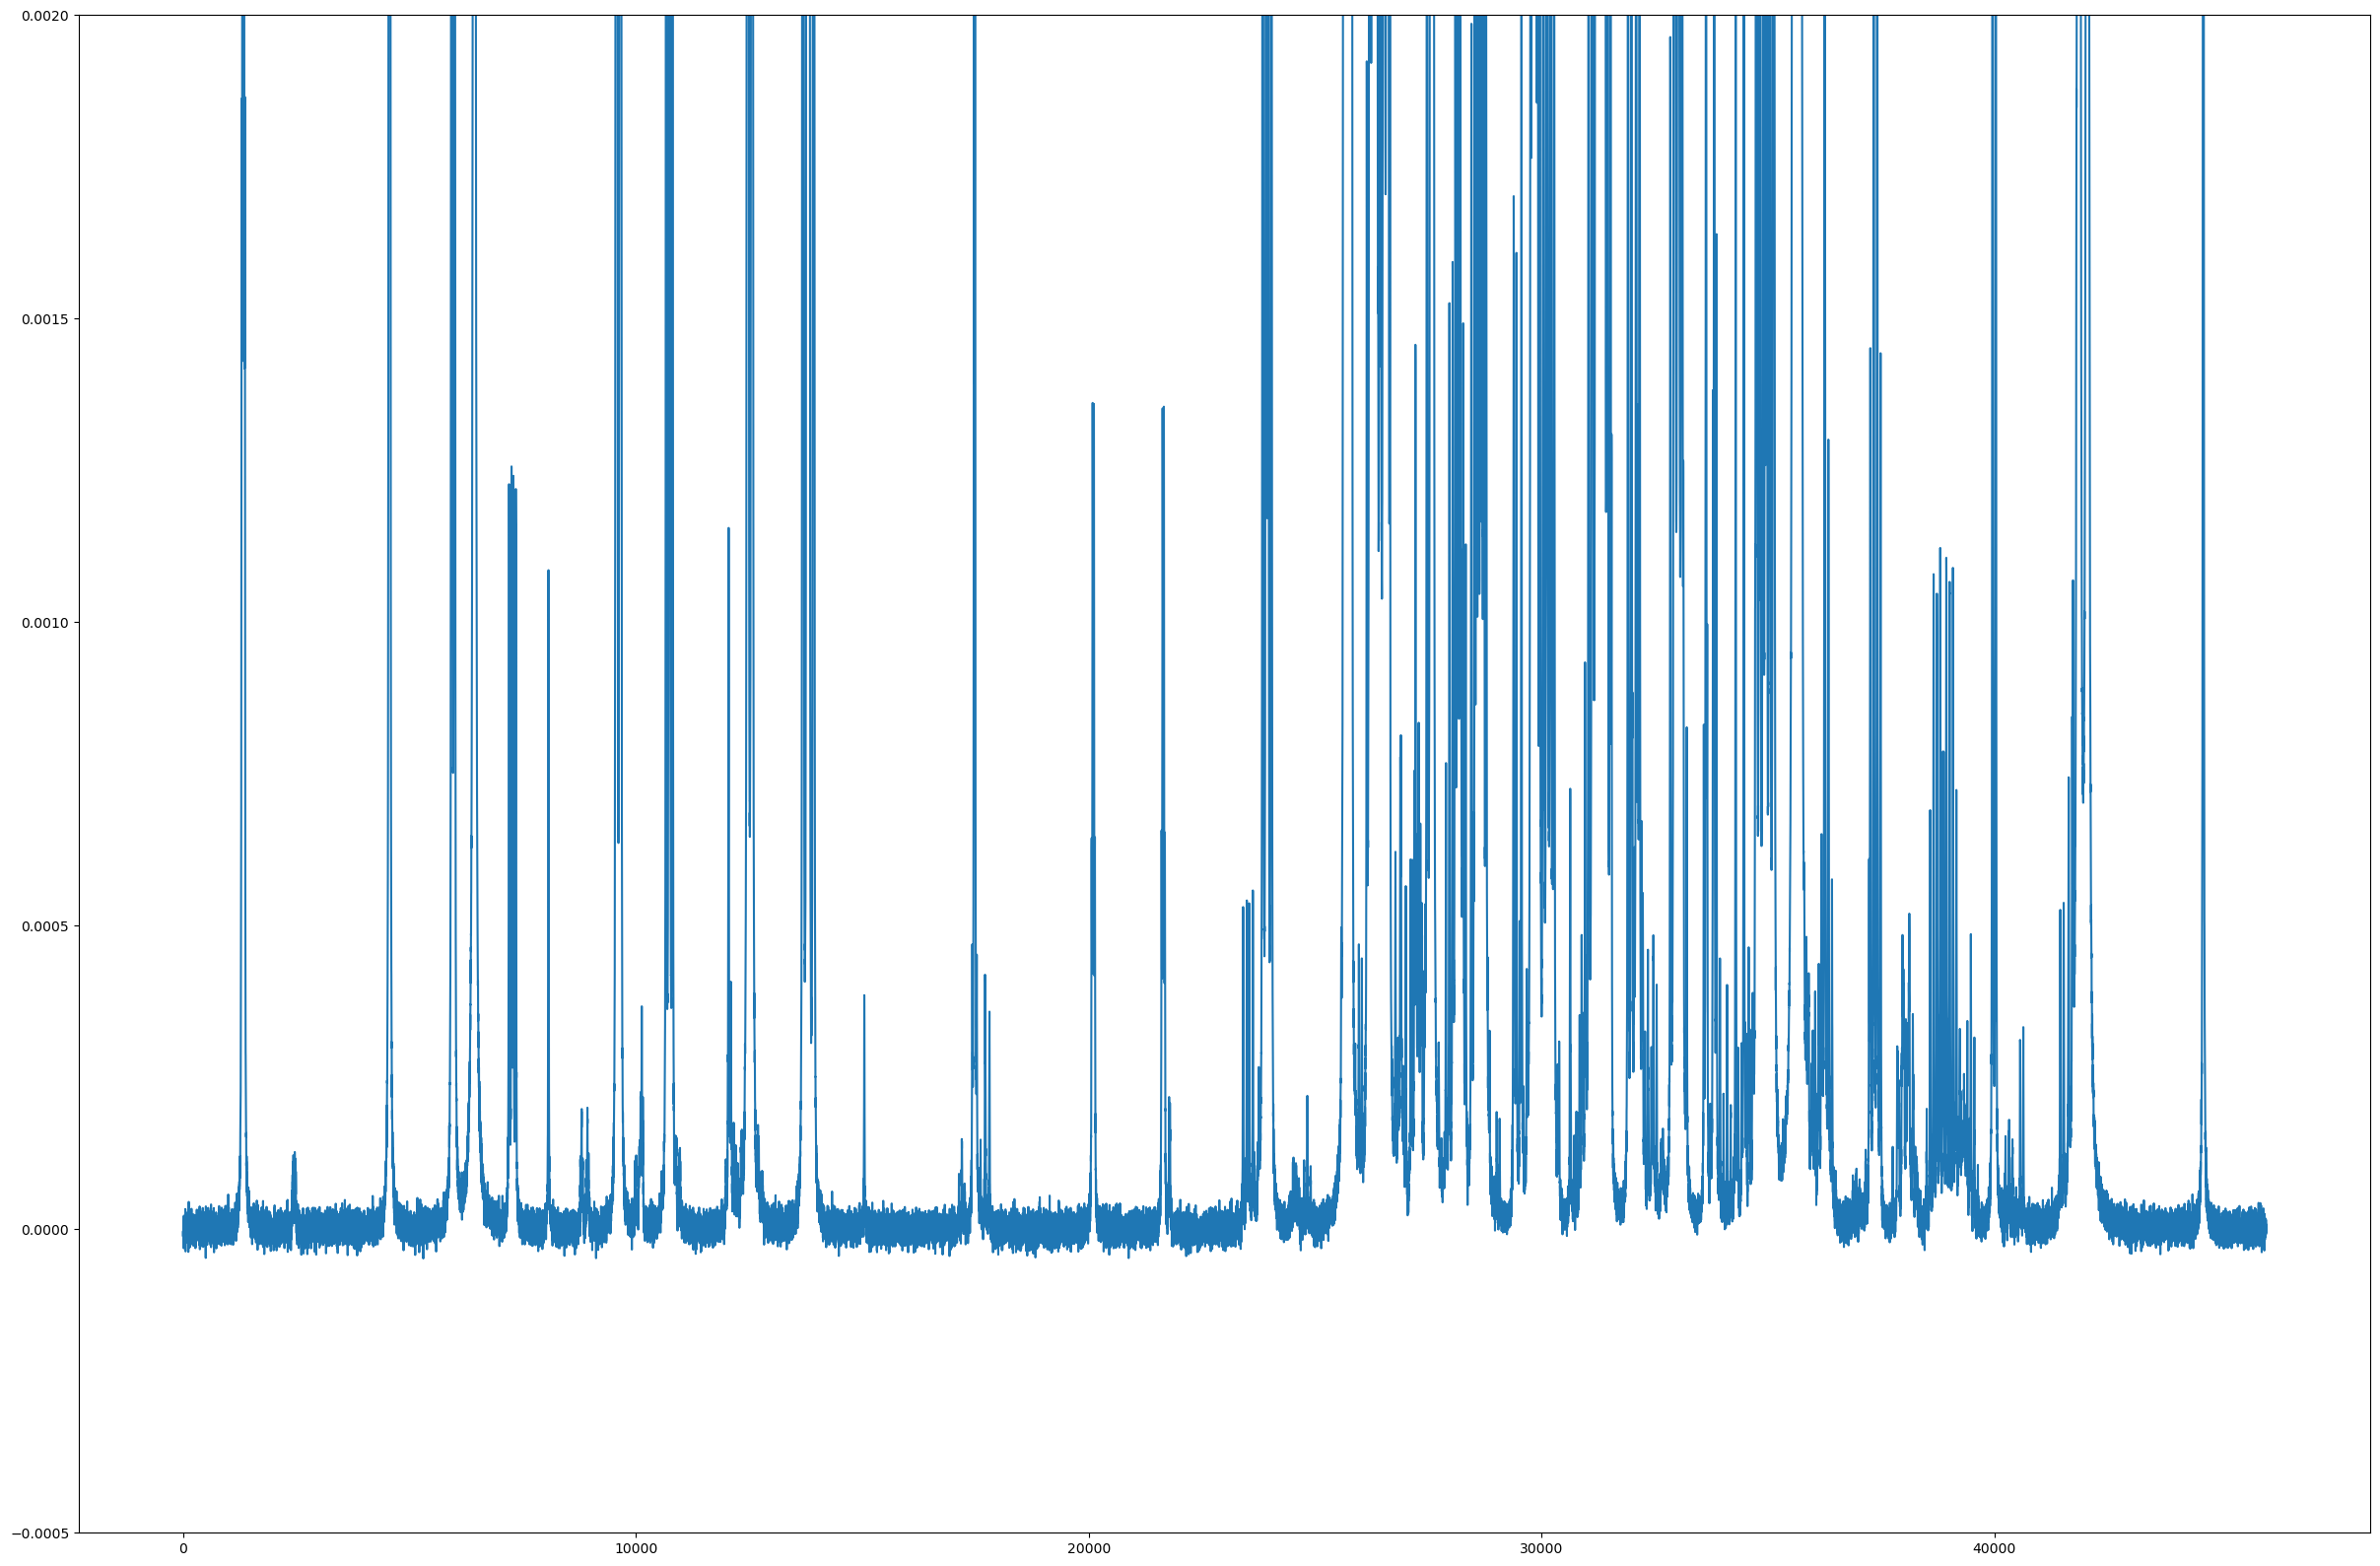

In [23]:
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.01)
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.002)
plt.show()

In [24]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

Overall MAPE:  10.461313
--------------------
5.31  - Min Value: 0.013  - Mean Value: 0.6
10.2  - Min Value: 0.0115  - Mean Value: 0.4
8.33  - Min Value: 0.0115  - Mean Value: 0.4
9.83  - Min Value: 0.0115  - Mean Value: 0.6
17.01  - Min Value: 0.0115  - Mean Value: 1.0
10.28  - Min Value: 0.0115  - Mean Value: 1.1
15.21  - Min Value: 0.0115  - Mean Value: 0.8
6.69  - Min Value: 0.0115  - Mean Value: 0.5
7.33  - Min Value: 0.0115  - Mean Value: 0.5
14.42  - Min Value: 0.0115  - Mean Value: 1.1


In [25]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  59.413166
--------------------
67.98  - Min Value: 0.0062  - Mean Value: 2.1
71.83  - Min Value: 0.006  - Mean Value: 3.7
52.64  - Min Value: 0.0066  - Mean Value: 4.3
58.43  - Min Value: 0.0094  - Mean Value: 4.3
50.18  - Min Value: 0.0068  - Mean Value: 4.9
55.15  - Min Value: 0.005  - Mean Value: 3.8
34.06  - Min Value: 0.0101  - Mean Value: 3.2
40.89  - Min Value: 0.0062  - Mean Value: 3.2
85.41  - Min Value: 0.0053  - Mean Value: 5.3
77.56  - Min Value: 0.0054  - Mean Value: 2.5


In [26]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  1.4246374223751452
--------------------
1.0
1.06
0.99
1.34
1.38
1.56
1.66
1.68
1.74
1.84


In [27]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  12.584356418151177
--------------------
1.07
1.06
1.02
1.13
15.37
16.05
16.25
19.34
25.57
28.98


In [28]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  26.336266387324883
--------------------
2.04
7.29
12.68
18.2
23.8
28.97
34.65
39.68
45.52
50.52


In [29]:
Pred = model_aq(OtherValSpectra[0])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 0.01s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])

Sinusoidal Baseline 1
tensor([0.4629, 0.6104, 0.3427, 0.7579, 0.4823, 0.5128, 0.4874, 0.5957, 0.6519,
        0.4308, 0.4196, 0.7002, 0.5617, 0.7485, 0.3370, 0.6391, 0.6025, 0.4948,
        0.5015, 0.3895, 0.5112, 0.9481, 0.4240, 0.4873, 0.6530, 0.4852, 0.6440,
        0.7460, 0.3566, 0.4403, 0.4464, 0.7183, 0.5147, 0.4277, 0.4583, 0.4408,
        0.5099, 0.5152, 0.7122, 0.3996, 0.4163, 0.5111, 0.6468, 0.3919],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
Sinusoidal Baseline 2
tensor([0.3915, 0.4314, 0.0921, 0.8007, 0.3930, 0.5212, 0.4296, 0.2406, 0.4055,
        0.5283, 0.4190, 0.4985, 0.7000, 0.4456, 0.6679, 0.1784, 0.7843, 0.6095,
        0.4535, 0.3402, 0.2473, 0.4729, 0.5561, 0.5350, 0.3856, 0.4543, 0.1728,
        0.0660, 0.3583, 0.3902, 0.4233, 0.4945, 0.3769, 0.4197, 0.5392, 0.4321,
        0.6636, 0.7234, 0.4853, 0.3527, 0.4732, 0.6741, 0.2716, 0.1608],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
HD-Range 1 - 0.01s a